In [521]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [522]:
#Importing data 
scoredf = pd.read_csv('creditscore.csv')
scoredf.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [523]:
#Removing unwanted characters
scoredf = scoredf.replace('_', '', regex=True)

In [524]:
#Checking for duplicates
scoredf['ID'].duplicated().sum()

0

In [525]:
scoredf['Customer_ID'].duplicated().sum()

87500

In [526]:
scoredf['Changed_Credit_Limit'].replace('', np.nan, inplace=True)

In [527]:

scoredf['Changed_Credit_Limit'] = scoredf['Changed_Credit_Limit'].astype(float)
scoredf['Changed_Credit_Limit'] = scoredf['Changed_Credit_Limit'].apply(lambda x: x if x >= 0 else 0)


In [528]:
scoredf['Changed_Credit_Limit'].isna().sum()

0

In [529]:
# scoredf.to_csv('credit.csv')

In [530]:
#Converting datatypes
scoredf['Age'] = scoredf['Age'].astype(int)
scoredf['Annual_Income'] = scoredf['Annual_Income'].astype(float)
scoredf['Monthly_Balance'] = scoredf['Monthly_Balance'].astype(float)
scoredf['Num_of_Delayed_Payment'] = scoredf['Num_of_Delayed_Payment'].astype(float)
scoredf['Outstanding_Debt'] = scoredf['Outstanding_Debt'].astype(float)


In [531]:
#Removing outliers
scoredf['Age'] =  scoredf['Age'][(scoredf['Age'] >= 0) & (scoredf['Age'] <= 100)]

In [532]:
scoredf['Age'].max()

100.0

In [533]:
#Defining functions
def replace_with_mode(df, group_col, target_col , new_col_name):
    mode_df = df.groupby(group_col)[target_col].agg(lambda x: x.mode().iloc[0] if not x.mode().iloc[0] == '' else np.nan ).reset_index()
    df = df.merge(mode_df, on=group_col, suffixes=('', '_mode'))
    df.rename(columns={f'{target_col}_mode': new_col_name}, inplace=True)
    df.drop(columns=[target_col], inplace=True)
    return df

In [534]:
#Filling missing values
user_mean_ages = scoredf.groupby('Customer_ID')['Age'].mean().round()
df_merged = scoredf.merge(user_mean_ages.rename('Mean_Age'), on='Customer_ID')
df_merged['Age'] = df_merged['Age'].fillna(df_merged['Mean_Age'])

scoredf = df_merged.drop(columns=['Mean_Age'])

In [535]:
#Replacing with mode
num_credit = scoredf.groupby('Customer_ID')['Num_Credit_Card'].min().reset_index()
mode_credit = scoredf.merge(num_credit, on='Customer_ID').rename(columns={'Num_Credit_Card_y': 'num_credit_cards'})
mode_credit.drop(columns=['Num_Credit_Card_x'], inplace=True)

In [536]:
#Replacing with mode
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Num_of_Loan' , 'num_of_loan')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Num_Bank_Accounts' , 'num_bank_accounts')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Interest_Rate' , 'interest_rate')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Occupation' , 'occupation')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Monthly_Inhand_Salary' , 'monthly_inhand_salary')


In [537]:
#Removing missing values
mode_credit.dropna(subset=['occupation'], inplace=True)

In [538]:
#Filling missing values
name = mode_credit['Name'].groupby(mode_credit['Customer_ID']).transform('first')
mode_credit['Name'] = mode_credit['Name'].fillna(name)


In [539]:
mode_credit['Monthly_Balance'] = mode_credit['Monthly_Balance'].dropna().apply(lambda x: x if x >= 0 else 0)
mode_credit = mode_credit[mode_credit['Delay_from_due_date'] >= 0]
mode_credit = mode_credit[mode_credit['Num_of_Delayed_Payment'] >= 0]


In [540]:
mode_credit.dropna(subset=['Monthly_Balance'], inplace=True)
mode_credit['Monthly_Balance'].isna().sum()

0

In [541]:
mode_credit['Monthly_Balance'].max()

1602.0405189622518

In [542]:
#Final dataframe
scoredf = mode_credit

# scoredf.columns = [col.lower() for col in scoredf.columns]

scoredf

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,num_credit_cards,num_of_loan,num_bank_accounts,interest_rate,occupation,monthly_inhand_salary
0,0x1602,CUS0xd40,January,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,80.41529543900253,HighspentSmallvaluepayments,312.494089,Good,4,4,3,3,Scientist,1824.843333
2,0x1604,CUS0xd40,March,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,81.699521264648,LowspentMediumvaluepayments,331.209863,Good,4,4,3,3,Scientist,1824.843333
3,0x1605,CUS0xd40,April,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,...,199.4580743910713,LowspentSmallvaluepayments,223.451310,Good,4,4,3,3,Scientist,1824.843333
5,0x1607,CUS0xd40,June,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4.0,...,62.430172331195294,!@9#%8,340.479212,Good,4,4,3,3,Scientist,1824.843333
6,0x1608,CUS0xd40,July,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8.0,...,178.3440674122349,LowspentSmallvaluepayments,244.565317,Good,4,4,3,3,Scientist,1824.843333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0x25fe8,CUS0x942c,March,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",20,6.0,...,140.58140274528395,HighspentMediumvaluepayments,410.256158,Poor,6,2,4,7,Mechanic,3359.415833
99995,0x25fe9,CUS0x942c,April,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",23,7.0,...,60.97133255718485,HighspentLargevaluepayments,479.866228,Poor,6,2,4,7,Mechanic,3359.415833
99996,0x25fea,CUS0x942c,May,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",18,7.0,...,54.18595028760385,HighspentMediumvaluepayments,496.651610,Poor,6,2,4,7,Mechanic,3359.415833
99997,0x25feb,CUS0x942c,June,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",27,6.0,...,24.02847744864441,HighspentLargevaluepayments,516.809083,Poor,6,2,4,7,Mechanic,3359.415833


In [543]:
print(scoredf['occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'MediaManager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


## Data Visualization And EDA

In [544]:
y = scoredf['Credit_Score']
X = scoredf.drop('Credit_Score', axis=1)

X.fillna(0, inplace=True)

In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=1 , test_size=0.2)
scoredf = pd.concat([X_train, y_train], axis=1)

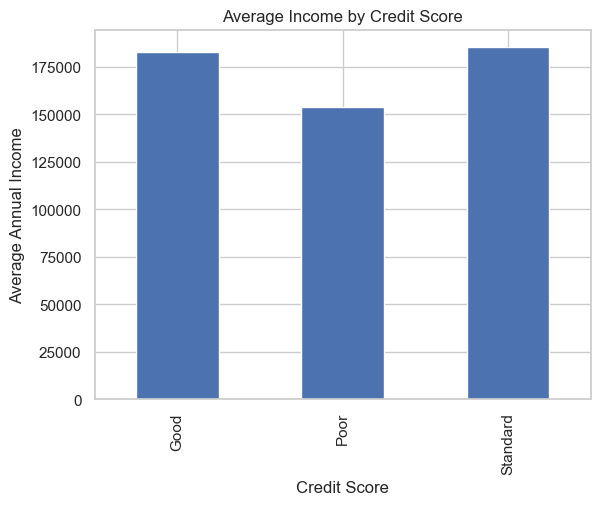

In [546]:

import matplotlib.pyplot as plt

scoredf.groupby('Credit_Score')['Annual_Income'].mean().plot(kind='bar', title='Average Income by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Annual Income')
plt.show()





In [547]:
scoredf.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Annual_Income',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'num_credit_cards', 'num_of_loan', 'num_bank_accounts', 'interest_rate',
       'occupation', 'monthly_inhand_salary', 'Credit_Score'],
      dtype='object')

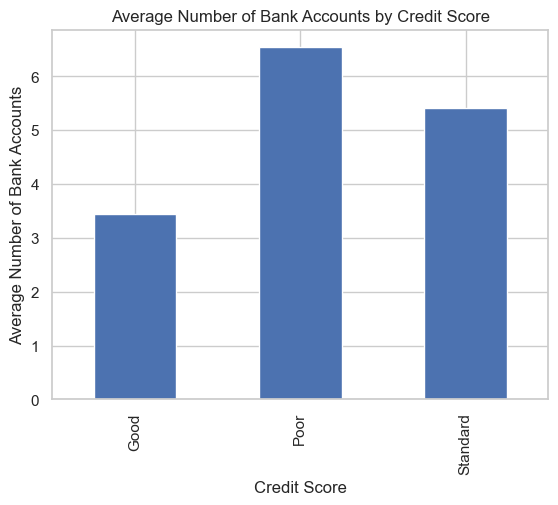

In [548]:
scoredf.groupby('Credit_Score')['num_bank_accounts'].mean().plot(kind='bar', title='Average Number of Bank Accounts by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Bank Accounts')
plt.show()


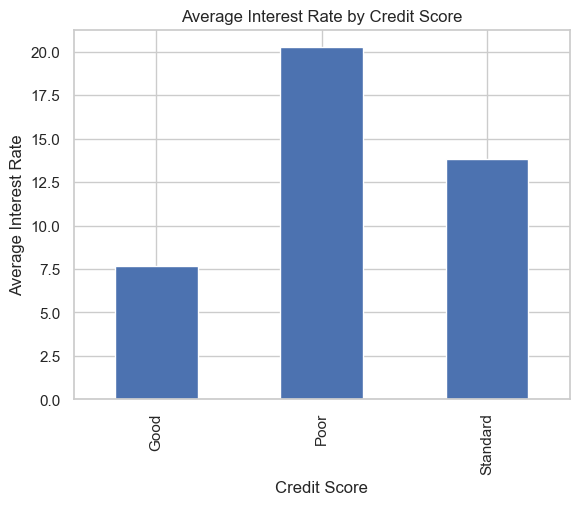

In [549]:
scoredf.groupby('Credit_Score')['interest_rate'].mean().plot(kind='bar', title='Average Interest Rate by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Interest Rate')
plt.show()


In [550]:
scoredf['Credit_Score'] = scoredf['Credit_Score'].map({'Good': 1, 'Standard': 2, 'Poor': 3})
scoredf['Credit_Score']

55180    1
63518    1
64010    2
44538    2
35441    2
        ..
23669    1
80901    1
55220    3
5722     2
85715    2
Name: Credit_Score, Length: 72456, dtype: int64

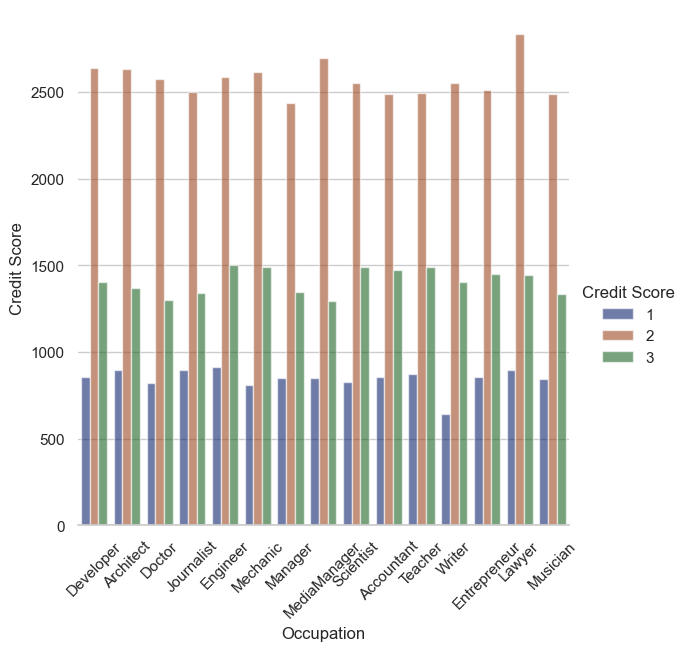

In [551]:

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=scoredf, kind="bar",
    x="occupation", y='Credit_Score', hue="Credit_Score",
    errorbar="sd", palette="dark", alpha=.6, height=6 , estimator='count' 
)
g.set_xticklabels(rotation=45)
g.despine(left=True)
g.set_axis_labels("Occupation", "Credit Score")
g.legend.set_title("Credit Score")



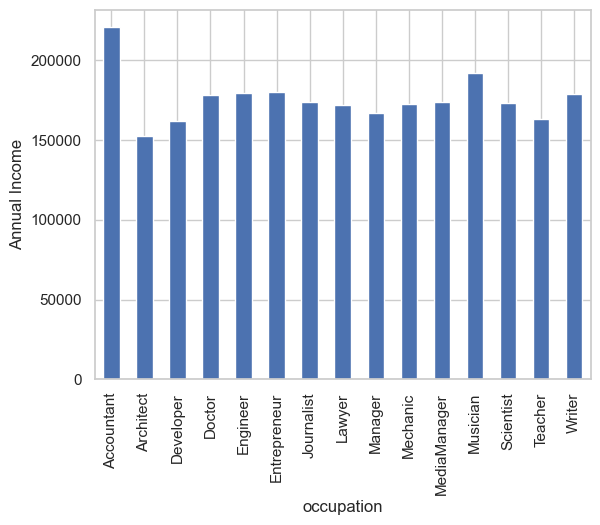

In [552]:


scoredf.groupby('occupation')['Annual_Income'].mean().plot(kind='bar')
plt.ylabel('Annual Income')
plt.show()


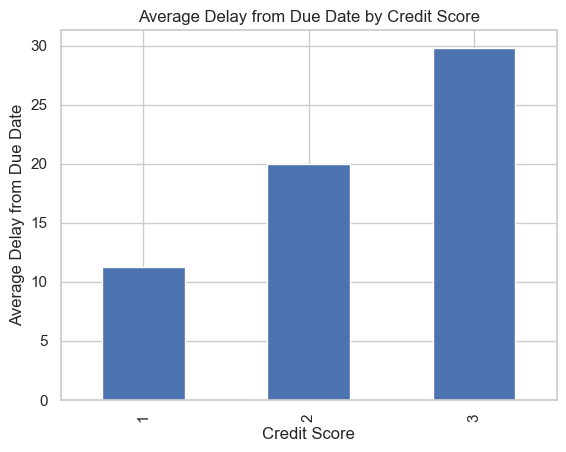

In [553]:
scoredf.groupby('Credit_Score')['Delay_from_due_date'].mean().plot(kind='bar', title='Average Delay from Due Date by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Delay from Due Date')
plt.show()


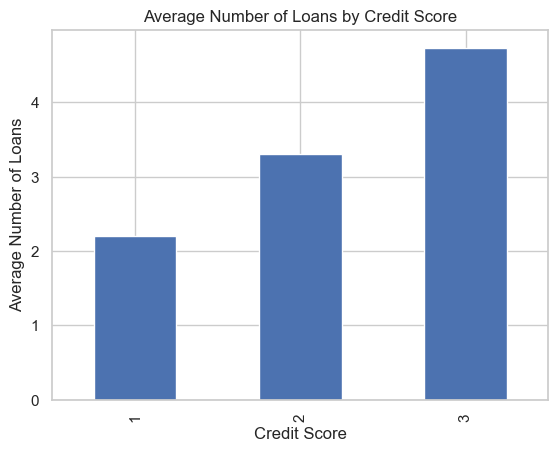

In [554]:
scoredf['num_of_loan'] = scoredf['num_of_loan'].astype(int)
avg_num_loans = scoredf.groupby('Credit_Score')['num_of_loan'].mean()
avg_num_loans.plot(kind='bar', title='Average Number of Loans by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Loans')
plt.show()

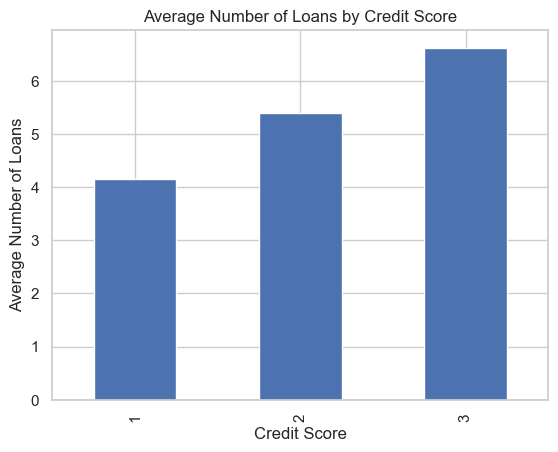

In [555]:
scoredf['num_of_loan'] = scoredf['num_credit_cards'].astype(int)
avg_num_loans = scoredf.groupby('Credit_Score')['num_of_loan'].mean()
avg_num_loans.plot(kind='bar', title='Average Number of Loans by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Loans')
plt.show()

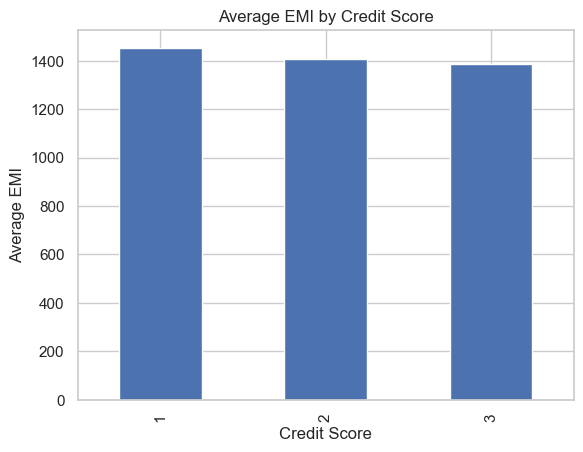

In [556]:

avg_emi = scoredf.groupby('Credit_Score')['Total_EMI_per_month'].mean()
avg_emi.plot(kind='bar', title='Average EMI by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average EMI')
plt.show()

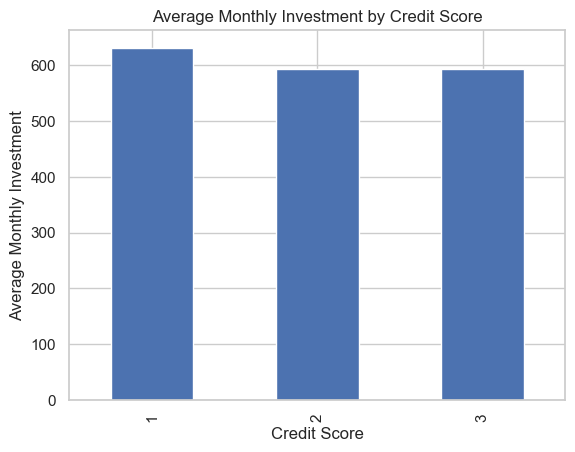

In [557]:
scoredf['Amount_invested_monthly'] = scoredf['Amount_invested_monthly'].astype(float)
avg_monthly_investment = scoredf.groupby('Credit_Score')['Amount_invested_monthly'].mean()
avg_monthly_investment.plot(kind='bar', title='Average Monthly Investment by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Monthly Investment')
plt.show()

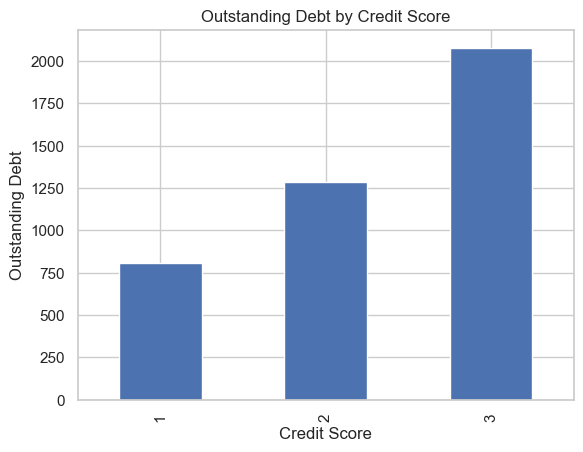

In [558]:
scoredf['monthly_investment'] = scoredf['Outstanding_Debt'].astype(float)
avg_monthly_investment = scoredf.groupby('Credit_Score')['Outstanding_Debt'].mean()
avg_monthly_investment.plot(kind='bar', title='Outstanding Debt by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Outstanding Debt')
plt.show()

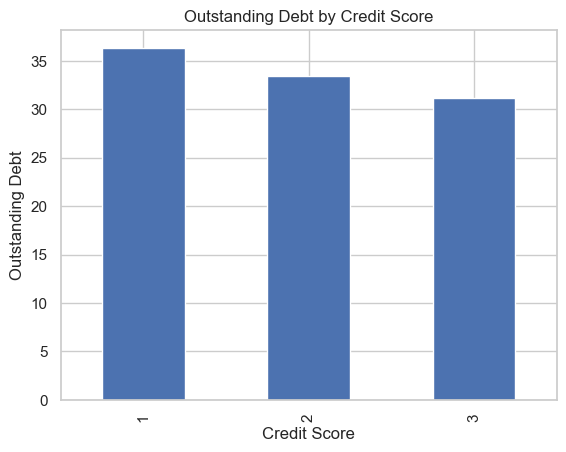

In [559]:
scoredf['monthly_investment'] = scoredf['Age'].astype(float)
avg_monthly_investment = scoredf.groupby('Credit_Score')['Age'].mean()
avg_monthly_investment.plot(kind='bar', title='Outstanding Debt by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Outstanding Debt')
plt.show()

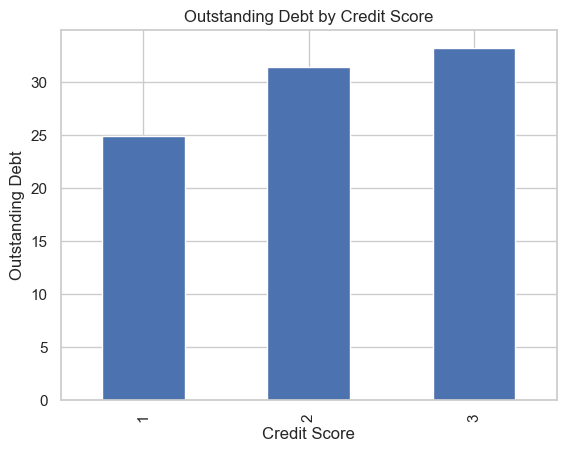

In [560]:
scoredf['monthly_investment'] = scoredf['Num_of_Delayed_Payment'].astype(float)
avg_monthly_investment = scoredf.groupby('Credit_Score')['Num_of_Delayed_Payment'].mean()
avg_monthly_investment.plot(kind='bar', title='Outstanding Debt by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Outstanding Debt')
plt.show()

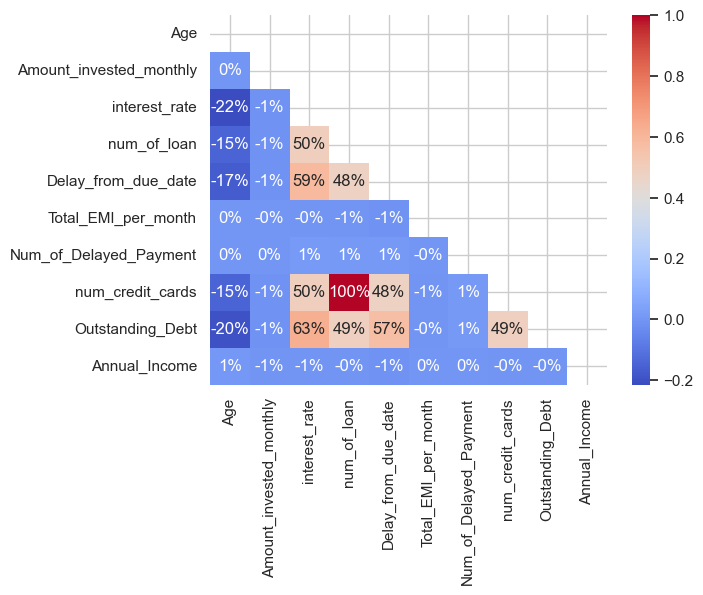

In [561]:


columns = [ 'Age' , 'Amount_invested_monthly' ,  'interest_rate' , 'num_of_loan'   , 'Delay_from_due_date' , 'Total_EMI_per_month'  , 'Num_of_Delayed_Payment'  , 'num_credit_cards' , 'Outstanding_Debt'  , 'Annual_Income'  ]

sns.heatmap(scoredf[columns].corr(), annot=True, cmap='coolwarm' ,square=False , mask=np.triu(scoredf[columns].corr()) , fmt='.0%')
plt.show()


##  Modeling

In [562]:


y = scoredf['Credit_Score']
X = scoredf.drop('Credit_Score', axis=1)

X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=1 , test_size=0.2)
scoredf = pd.concat([X_train, y_train], axis=1)



In [563]:
columns = [  'Age'  ,  'interest_rate'    , 'Delay_from_due_date'   , 'Num_of_Delayed_Payment' , 'num_bank_accounts'  , 'num_credit_cards' , 'Outstanding_Debt'  , 'Annual_Income' ]

X_train = np.array(X_train[columns])
X_test = np.array(X_test[columns])

In [564]:
X_train[0]

array([3.6000000e+01, 6.0000000e+00, 1.9000000e+01, 8.0000000e+00,
       6.0000000e+00, 5.0000000e+00, 1.0526500e+03, 1.0233328e+05])

## Loggistics Reggration

In [565]:
scoredf['occupation'] = scoredf['occupation'].map({'Scientist':1, 'Teacher':2, 'Engineer':3, 'Entrepreneur':4, 'Developer':5, 'Lawyer':6,
 'MediaManager':7, 'Doctor':8, 'Journalist':9, 'Manager':10, 'Accountant':11, 'Musician':12,
 'Mechanic':13, 'Writer':14, 'Architect':15})
scoredf['occupation']

77715    12
86174    15
87399     6
53035     5
85098     2
         ..
25034     6
51420    12
85726     9
46710    13
65771    13
Name: occupation, Length: 57964, dtype: int64

In [566]:
scoredf['Payment_of_Min_Amount'] = scoredf['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0 , 'NM' : 2})
scoredf['Payment_of_Min_Amount']

77715    1
86174    0
87399    0
53035    0
85098    0
        ..
25034    0
51420    2
85726    0
46710    0
65771    0
Name: Payment_of_Min_Amount, Length: 57964, dtype: int64

In [567]:
scoredf['Payment_of_Min_Amount'].isnull().sum()

0

In [568]:
scoredf['occupation'].isnull().sum()

0

In [569]:

clf = LogisticRegression()
clf.fit(X_train, y_train)



LogisticRegression()

In [570]:


train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

Train accuracy: 53.32


In [571]:

p = clf.predict(X_test)


In [572]:


accuracy = accuracy_score(y_test, p)
print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 53.16%


## Random Forest 


In [599]:
clf = RandomForestClassifier(n_estimators=150 , random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=150, random_state=0)

In [600]:

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")
p = clf.predict(X_test)
accuracy = accuracy_score(y_test, p)
print(f"Model accuracy: {accuracy*100:.2f}%")


Train accuracy: 95.04
Model accuracy: 77.64%


In [601]:
import joblib

joblib.dump(clf, 'credit.pkl')

['credit.pkl']

### This is the best model 👆

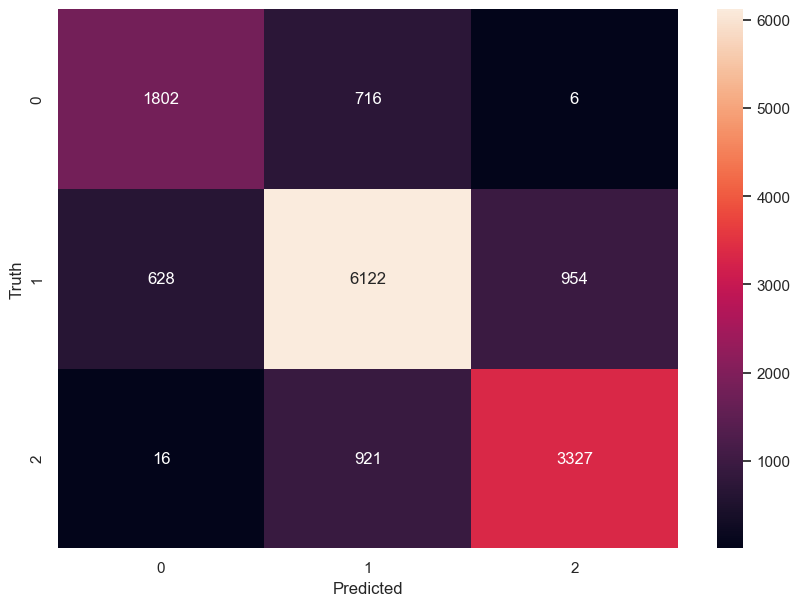

In [604]:

cm = confusion_matrix(y_test, p)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


### Classification Report

In [606]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = clf.predict(X_test)
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           1       0.74      0.71      0.73      2524
           2       0.79      0.79      0.79      7704
           3       0.78      0.78      0.78      4264

    accuracy                           0.78     14492
   macro avg       0.77      0.76      0.77     14492
weighted avg       0.78      0.78      0.78     14492



### Random Forest Hyperparameter Tuning

In [575]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV 

In [576]:
param_grid = { 
	'n_estimators': [25, 50, 100, 150], 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9 , None], 
	
} 


In [577]:


# grid_search = GridSearchCV(RandomForestClassifier(), 
# 						param_grid=param_grid) 
# grid_search.fit(X_train, y_train) 
# print(grid_search.best_estimator_) 


In [578]:
# grid_search = RandomizedSearchCV(RandomForestClassifier(), 
# 						param_distributions=param_grid , cv=5 , n_jobs=-1 , n_iter=10) 
# grid_search.fit(X_train, y_train) 
# print(grid_search.best_estimator_) 

In [579]:
clf = RandomForestClassifier(max_features=None, n_estimators=150, random_state=0 )
clf.fit(X_train, y_train)


RandomForestClassifier(max_features=None, n_estimators=150, random_state=0)

In [580]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

Train accuracy: 95.04


In [581]:
p = clf.predict(X_test)

In [582]:

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 77.36%


##  AdaBoostClassifier

In [583]:
from sklearn.ensemble import AdaBoostClassifier

In [584]:
clf = AdaBoostClassifier( n_estimators=600, random_state=0 )
clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=600, random_state=0)

In [585]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

p = clf.predict(X_test)

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 64.54
Model accuracy: 64.50%


##  MLPClassifier

In [586]:
from sklearn.neural_network import MLPClassifier

In [587]:
clf = MLPClassifier(max_iter=1000, tol=1e-8 , random_state=0 , verbose=True  , hidden_layer_sizes= (50,100 ) )
clf.fit(X_train, y_train)

Iteration 1, loss = 19.68014464
Iteration 2, loss = 19.66585065
Iteration 3, loss = 18.79761976
Iteration 4, loss = 19.53848834
Iteration 5, loss = 19.09198123
Iteration 6, loss = 19.26992842
Iteration 7, loss = 17.90612686
Iteration 8, loss = 17.17975526
Iteration 9, loss = 17.25208373
Iteration 10, loss = 17.04579348
Iteration 11, loss = 17.30525774
Iteration 12, loss = 16.81533828
Iteration 13, loss = 16.20286423
Iteration 14, loss = 15.47931616
Iteration 15, loss = 16.32129133
Iteration 16, loss = 14.93905931
Iteration 17, loss = 14.99729069
Iteration 18, loss = 13.94979119
Iteration 19, loss = 15.10049202
Iteration 20, loss = 13.24158794
Iteration 21, loss = 13.14015134
Iteration 22, loss = 14.83587956
Iteration 23, loss = 13.78065259
Iteration 24, loss = 11.97033498
Iteration 25, loss = 10.70369406
Iteration 26, loss = 10.71234973
Iteration 27, loss = 10.86363619
Iteration 28, loss = 10.62604781
Iteration 29, loss = 9.92023676
Iteration 30, loss = 10.12093782
Iteration 31, loss =

MLPClassifier(hidden_layer_sizes=(50, 100), max_iter=1000, random_state=0,
              tol=1e-08, verbose=True)

In [588]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

p = clf.predict(X_test)

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 56.63
Model accuracy: 56.40%


## ExtraTreesClassifier

In [589]:
clf = ExtraTreesClassifier(max_features=None, n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

ExtraTreesClassifier(max_features=None, n_estimators=200, random_state=0)

In [590]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

p = clf.predict(X_test)

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 95.04
Model accuracy: 77.01%


##  Feature Selection

In [591]:
from sklearn.feature_selection import SelectFromModel

In [592]:
selector = SelectFromModel(clf).fit(X_train, y_train)

In [593]:
X_train_selected = selector.transform(X_train)

X_test_selected = selector.transform(X_test)


In [594]:
X_train_selected

array([[6.00000e+00, 1.90000e+01, 8.00000e+00, 1.05265e+03],
       [1.00000e+00, 0.00000e+00, 1.00000e+01, 1.03280e+02],
       [1.20000e+01, 3.00000e+00, 1.10000e+01, 2.26980e+02],
       ...,
       [5.00000e+00, 1.60000e+01, 2.20000e+01, 1.07584e+03],
       [1.60000e+01, 2.60000e+01, 1.60000e+01, 5.60410e+02],
       [3.00000e+00, 1.10000e+01, 6.00000e+00, 1.18175e+03]])

In [595]:
clf = RandomForestClassifier(n_estimators=150 , random_state=0)
clf.fit(X_train_selected, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

In [596]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train_selected))
print(f"Train accuracy: {train_accuracy*100:.2f}")
p = clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, p)
print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 93.83
Model accuracy: 73.74%
